# ----------------------------------------使用pytorch实现Transformer-------------------------

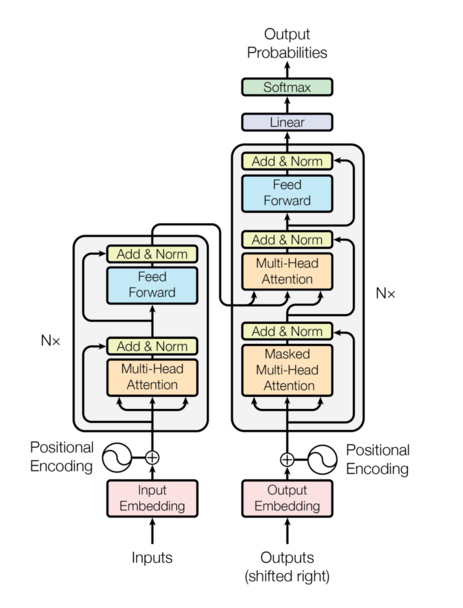

# ------------------------------------------数据预处理------------------------------------------------

### 0、导入包

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

### 1、数据预处理
- 搭建一个很简答的词典，德语翻译成英文，自行构建词典
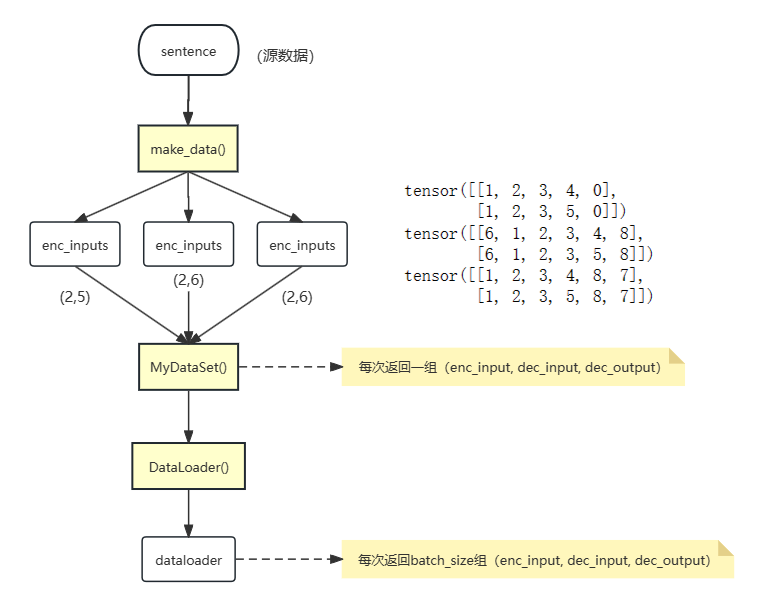

In [2]:
# S:起始标记，E：结束标记，P:padding，将当前序列补齐之最长序列长度的占位符
sentence = [
    #   enc_input编码器输入        dec_input             dec_output
    ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'], 
    ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E'],
]    # 德语：我想喝啤酒作为编码器输入，    

# 构建词典， padding用0表表示
# 源词典
src_vocab = {'P':0, 'ich':1, 'mochte':2, 'ein':3, 'bier':4, 'cola':5}
src_vocab_size = len(src_vocab)

# 目标词典（包含特殊字符）
tgt_vocab = {'P':0, 'i':1, 'want':2, 'a':3, 'beer':4, 'coke':5, 'S':6, 'E':7, '.':8}
# 词典中编号和词元的转换
idx2word = {v:k for k, v in tgt_vocab.items()}
tgt_vocab_size = len(tgt_vocab)

src_len = 5  # 设定输入序列enc_input的最长序列长度
tgt_len = 6  # 设定输出序列dec_input/dec_ouput的最长序列长度 

In [3]:
# 将原始输入序列转换为token也就是序列号表示
def make_data(sentence):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentence)):
        enc_input = [src_vocab[word] for word in sentence[i][0].split()]
        dec_input = [tgt_vocab[word] for word in sentence[i][1].split()]
        dec_output = [tgt_vocab[word] for word in sentence[i][2].split()]
        
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_outputs.append(dec_output)
    # torch.LongTensor专门用于储存整数型，tensor则可以表示浮点，整数等
    return torch.LongTensor(enc_inputs),torch.LongTensor(dec_inputs),torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentence)

print(' enc_inputs: \n', enc_inputs)  # enc_inputs: [2,5]
print(' dec_inputs: \n', dec_inputs)  # dec_inputs: [2,6]
print(' dec_outputs: \n', dec_outputs) # dec_outputs: [2,6]

 enc_inputs: 
 tensor([[1, 2, 3, 4, 0],
        [1, 2, 3, 5, 0]])
 dec_inputs: 
 tensor([[6, 1, 2, 3, 4, 8],
        [6, 1, 2, 3, 5, 8]])
 dec_outputs: 
 tensor([[1, 2, 3, 4, 8, 7],
        [1, 2, 3, 5, 8, 7]])


In [4]:
# 使用Dataset加载数据
class MyDataSet(Data.Dataset):
    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs
        
    def __len__(self):
        # enc_inputs.shape = [2, 5], 所以返回2
        return self.enc_inputs.shape[0]
    
    # 根据idx返回的是一组enc_input, dec_input, dec_output
    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

In [5]:
# 打包训练用的数据集，构建DataLoader
loader = Data.DataLoader(dataset=MyDataSet(enc_inputs, dec_inputs, dec_outputs), batch_size=2, shuffle=True)

### 2、模型超参数

In [6]:
# 用来表示一个词的向量长度
d_model = 512

# FFN的隐藏层的神经元个数
d_ff = 2048

# 分头后的q, k, v词向量对的长度，依照原文设为64
d_k = d_v = 64

# Encoder 和 Decoder的个数
n_layers = 6

# 多头注意力中head的个数
n_heads = 8

# -----------------------------------------通用的函数方法----------------------------------------------

### 3、位置编码 Positional Encoding
- 用于为输入的词向量添加位置编码
- 思路：
    - 先构建一个包含5000长度的向量表
    - 在构建关于位置信息的矩阵，使用余弦衰减函数作为位置信息编码
    - 因为我们在构建注意力机制时希望当前位置和其他位置之间的相似度可以随着距离的增大而逐渐减小。余弦衰减函数正好满足这样的需求，因为它越靠近原点的地方越陡峭，在远离原点的地方则越来越平缓。这样就可以让相近的位置有更多的交互机会，而较远的位置则较少参与交互。
    - 构建的过程省略

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # dropout原文是0.1
        # max_len是假设一个句子最多包含5000个token
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # 开始位置编码部分，先生成一个max_len * d_model的矩阵，即5000*512
        # 5000是一个句子中最多的token数， 512是一个token用多长的向量来表示，5000*512这个矩阵用于表示一个句子的信息
        pe = torch.zeros(max_len, d_model)
        # pos用于表示每个位置的索引，从0到5000
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # pos.shape=([5000, 1])
        
        # 先把括号内的分时求出来，pos是[5000,1]，分母是256，通过广播机制相乘后是[5000, 256]
        # 计算一个余弦衰减函数， 将输入的位置信息转化为向量模式
        div_term = pos / pow(10000.0, torch.arange(0, d_model, 2).float() / d_model) 
        
        # 在取正余弦，周期型的取正弦和余弦有助于捕获更多位置信息
        pe[:, 0::2] = torch.sin(div_term)
        pe[:, 1::2] = torch.cos(div_term)
        
        # 一个句子要做一次配pe， 一个batch中会有多个句子，所以增加以为用来和输入的一个batch的数据相加时做广播
        pe = pe.unsqueeze(0) # [5000,512]到[15000,512]
        # 将pe作为固定参数保存到缓冲区，不会被更新
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x时输入[batch_size, seq_len, d_model]
        # 5000时预定义的最大seq_len, 也就是把至多这么多位置的位置函数都计算好了，使用的时候直接相加就行了
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x) # 加入降噪，防止过拟合， 返回[batch_size, seq_len, d_model]

### 4、ScaledDotProductAttention
- 用于计算缩放点积注意力， 在MultiHeadAttention中被调用

In [8]:
class ScaledDotProductionAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductionAttention, self).__init__()
        
    def forward(self, Q, K, V, attn_mask):
        # Q: [batch_size, n_heads, len_q, d_k]
        # K: [batch_size, n_heads, len_k, d_k]
        # V: [batch_size, n_heads, len_v(=len_k), d_v]
        # 总共使用两处自注意力， 一处时自注意力，一处时掩蔽自注意力
        # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        
        # 1、计算注意力分数QK^T/sqrt(d_k),
        # np.sqrt(d_k) 是一个平方根函数，它可以将一个非负实数的平方根提取出来。除以 sqrt(d_k) 来降低结果的数值大小，使其落入一个小范围。
        # 为什么要除一个根号d_k？这是因为点积的数量级增长很大，因此将 softmax 函数推向了梯度极小的区域
        # 这样做的目的是使softmax函数能够更加稳定地运行，从而提高模型的性能和鲁棒性。
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        
        # 2、进行mask和softmax
        # mask为True的地方会被设置为-1e9，相当于不考虑
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores) # attn:[batch_szie, n_heads, len_q, len_k]
        # 3、乘V得到最终的加权和
        context = torch.matmul(attn, V) # context:[batch_size, n_heads, len_q, d_v]
        # 返回的context: [batch_size, n_heads, len_q, d_v]本质上还是batch_size个句子，
        # 只不过每个句子中词向量维度512被分成了8个部分，分别由8个头各自看一部分，每个头算的是整个句子(一列)的512/8=64个维度，最后按列拼接起来
        
        return context # [batch_size, n_heads, len_q, d_v]

### 4、多头自注意力 MultiHeadAttention
- 多头注意力的实现， Transformer的核心
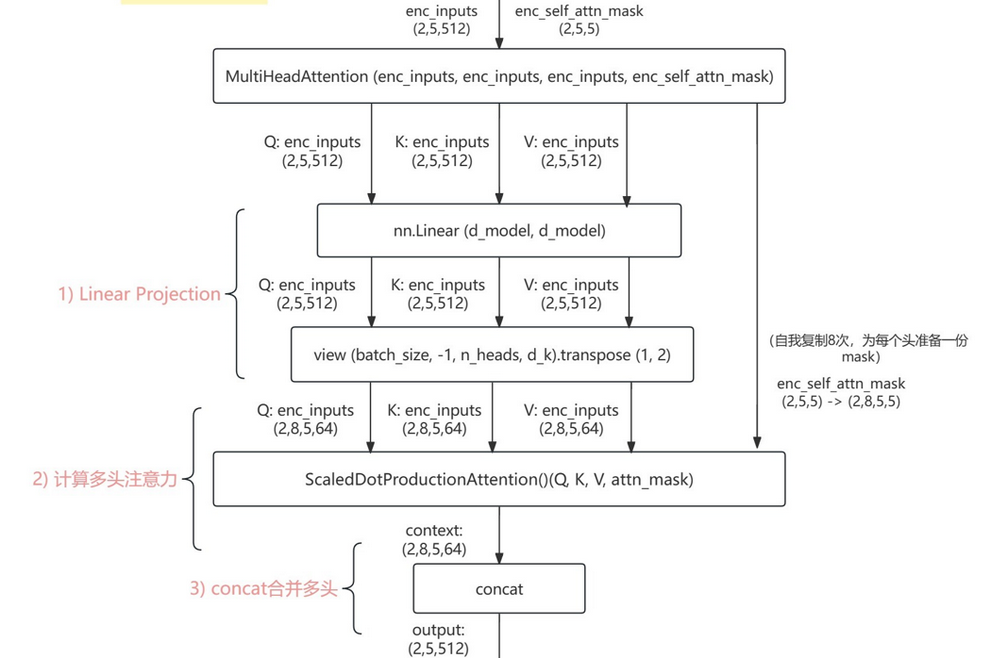
- 原来一个头对应512个特征，现在分为8个头，每个头处理64个特征

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        # input_Q:[batch_size, len_q, d_model] len_q是作为query的句子的长度，比如enc_inputs(2, 5, 512), 句子长度5就是len_q
        # input_K:[batch_size, len_k, d_model]
        # input_V:[batch_size, len_v(=len_k), d_model]
        
        residual, batch_size = input_Q, input_Q.size(0)
        
        # 1、线性投影：通过原始输入，映射出QKV，然后调整形状，准备多个头，每个头对应64个特征
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # Q:[batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # K:[batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2) # V:[batch_size, n_heads, len_v, d_k]
        
        # 2、计算注意力
        # 先自我复制n_heads次，为每个头准备一份mask
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask:[batch_size, n_heads, seq_len, seq_len]
        context = ScaledDotProductionAttention()(Q, K, V, attn_mask) # context:[batch_size, n_heads, len_q, d_v]
        
        # 3、concat部分
        context = torch.cat([context[:,i,:,:] for i in range(context.size(1))], dim=-1)
        output = self.concat(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual) # output:[batch_size, len_q, d_mdoel] 这一步加了残差

### 5、前馈网络(MLP)和层归一化FeedForward Networks
- 对应Feed Forward和 Add & Norm层归一化

In [36]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self):
        super(PositionwiseFeedForward, self).__init__()
        # 前馈神经网络也就是MLP多层感知机
        self.fc = nn.Sequential(
           nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    
    def forward(self, inputs):
        """inputs:[batch_size, seq_len, d_model]"""
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # 先残差连接，然后层归一化从右往左计算

### 6、Pad Mask
- 首先我们要清楚，这是一个计算mask的函数，它的返回是一个布尔矩阵，为True的位置是需要被mask掉的，False的位置是不需要动的
- 其次这个函数是理解Transformer代码中非常重要的一环，因为我们输入模型的句子有长有短，我们用占位符P统一补足成了最长的那个句子的长度，而这些占位符是没有意义的，不能让他们吸收到query的注意力，因此我们要把这些位置设为True
- 这个计算出的mask在何时被使用呢？
    - 在query和key的转置相乘得出（len_q,len_k）这个注意力分数矩阵以后，将使用本函数得到的mask来掩盖相乘结果矩阵
    - 原来的相乘结果矩阵（len_q,len_k）中第 i 行第 j 列的意义是“作为q的序列中第i个词对作为k的序列中第j个词的注意力分数”，而第 i 整行就是q中这个词对k中所有词的注意力，第 j 整列就是q中所有词对k中第j个词的注意力分数，作为padding，q中的所有词都不应该注意它，因此对应列均需设为True
- 为什么只有k的padding位被mask了，q的padding位为什么没被mask？（即此函数的返回矩阵为什么只有最后几列是True，最后几行不应该也是True么）
    - 按理来说是这样的，作为padding不该被别人注意，同时它也不该注意别人，计算出的padding对其他词的注意力也是无意义的，我们这里其实是偷了个懒，但这是因为：q中的padding对k中的词的注意力我们是不会用到的，因为我们不会用一个padding字符去预测下一个词，并且它的向量表示不管怎么更新都不会影响到别的q中别的词的计算，所以我们就放任自流了。但k中的padding不一样，如果不管它将无意义的吸收掉大量q中词汇的注意力，使得模型的学习出现偏差。
    - p.s. 哈佛团队也是这么实现的

In [37]:
# 为enc_input和 dec_input做一个mask，把占位符P的token（也就是0）mask掉
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    
    # seq_k.data.eq(0)返回一个相同大小的布尔张量，seq_k元素等于0的位置为True， 否则为False
    # .unsqueeze(1)扩充维度
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    
    # 要为每一个q提供一份k， 所以把第二维度扩展了q次
    # expand并非真正加倍内存，知识重复了引用，对任意引用的修改都会修改原始值
    # 不修改这个mask，用来节省内存
    
    return pad_attn_mask.expand(batch_size, len_q, len_k) # return :[batch_size, len_q, len_k]

# ---------------------------------------------Encoder----------------------------------------------------

### 7、Encoder Layer
- 包含一个MultiHeadAttention和一个FFN
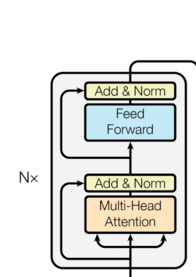

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PositionwiseFeedForward()
        
    def forward(self, enc_inputs, enc_self_attn_mask):
        # enc_inputs:[batch_size, scr_len, d_model]
        # enc_self_attn_mask:[batch_size, scr_len, src_len]
        
        # Q,K,V均为enc_inputs
        enc_ouputs = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # [batch_size, src_len, d_model]
        enc_ouputs = self.pos_ffn(enc_ouputs) # [batch_size, scr_len, d_model]
        
        return enc_ouputs # [batch_size,  src_len, d_mdoel]

### 8、Encoder
- 包含一个源序列词向量嵌入nn.Embedding、一个位置编码和6个Encoder Layer
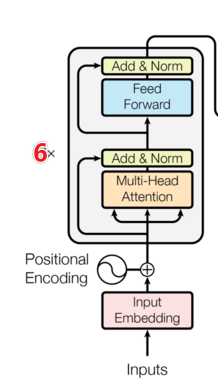

In [39]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # 使用torch自带的词嵌入，输入是词元数和每个词元使用多少维特征表示
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        
        self.pos_emb = PositionalEncoding(d_model)
        
        # 创建6个编码器，作为list
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        # enc_inputs:[batch_size, src_len]
        # 第一步词嵌入会将输入张量形状改变
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len]-->[batch_size, src_len, d_model]

        # 加入位置编码，张量形状不变
        enc_outputs = self.pos_emb(enc_outputs) # -->[batch_size, src_len, d_model]

        # 准备mask
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len] 和输入形状一样

        # 使用6个编码器
        for layer in self.layers:
            enc_outputs = layer(enc_outputs, enc_self_attn_mask)

        return enc_outputs # [batch_size, src_len, d_model]

In [40]:
encoder = Encoder()
print(encoder)

Encoder(
  (src_emb): Embedding(6, 512)
  (pos_emb): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=512, out_features=512, bias=True)
        (W_K): Linear(in_features=512, out_features=512, bias=True)
        (W_V): Linear(in_features=512, out_features=512, bias=True)
        (concat): Linear(in_features=512, out_features=512, bias=True)
      )
      (pos_ffn): PositionwiseFeedForward(
        (fc): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
    )
  )
)


# ---------------------------------------------Decoder----------------------------------------------------

### 9、Subsequence Mask
- 掩蔽自注意力
- 对应Transformer模型架构中Decoder的第一个掩蔽注意力，防止模型看到未来时刻的输入
- 在推理的时候，是看不到还未推理的单词的所以在训练时也需要将未来时刻的词元掩蔽掉
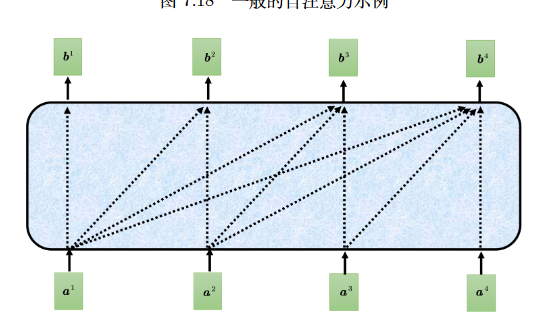

In [41]:
# 用于获取对后续位置的掩码，防止在预测过程中看到未来时刻的输入
def get_attn_subsequence_mask(seq):
    
    # seq:[batch_size, tgt_len]
    # batch_size个tgt_len * tgt_len的mask矩阵
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    
    # np.triu是生成一个upper traingular matrix上三角矩阵，K是相对主对角线的偏移量
    # k=1是之不包含住对角线
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte() # 因为只有0，1所以使用byte节省内存
    
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

# 没有理解代码意思！

### 10、DecoderLayer
- 包含两个MultiHeadAttention和一个FFN
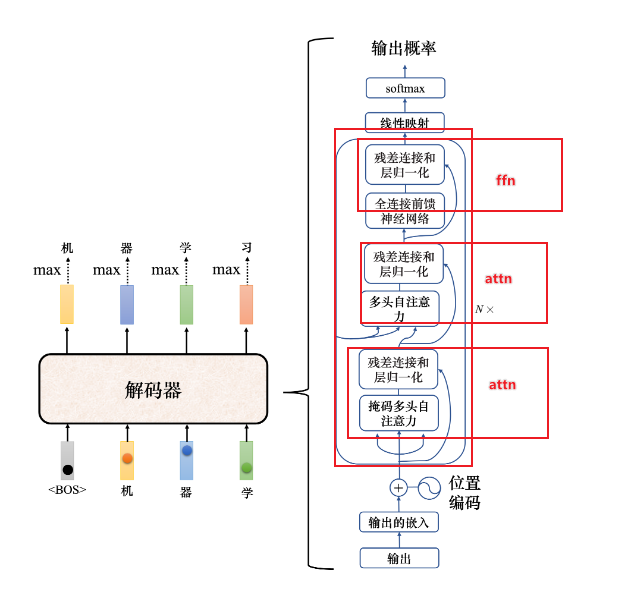

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PositionwiseFeedForward()
        
    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        # dec_inputs: [batch_size, tgt_len, d_model]
        # enc_outputs:[batch_size, src_len, d_model]
        # dec_self_attn_mask:[batch_size, tgt_len, d_model]
        # dec_enc_attn_mask:[batch_size, tgt_len, src_len] 前者是Q后者是K
        
        # 第一个掩码自注意力，输入是上一个输出，所以QKV都是一样的
        dec_outputs = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        
        # 第二个多头自注意力，并且使用的是Q，去查询编码器输出的K，V也是编码器输出的！
        dec_outputs = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        
        # 对后一个是ffw层
        dec_outputs = self.pos_ffn(dec_outputs)
        
        return dec_outputs # [batch_size, tgt_len, d_model]

### 11、Decoder
- 包含一个目标序列词向量序列嵌入，一个位置编码和6个Decoder Layer
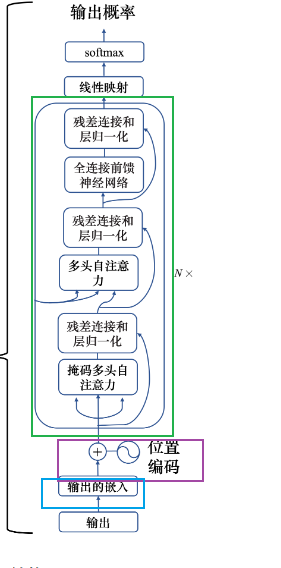

In [48]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
        
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        # dec_inputs:[batch_size, tgt_len] 对应Q
        # enc_inputs:[batch_size, src_len] 对应K V
        # enc_outputs:[batch_size, src_len, d_model] 用来计算padding mask
        
        # 词嵌入
        dec_outputs = self.tgt_emb(dec_inputs) 
        
        # 添加位置编码，并转移到cuda
        dec_outputs = self.pos_emb(dec_outputs).cuda() 
        
        # 计算占位符需要的掩码
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda()  
        
        # 计算掩码自注意力需要的掩码
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda()
        
        # 将两个掩码合并在一起，大于0的位置是需要mask的, 这是第一个掩码自注意力需要的mask
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda()
        
        # 这是第二个多头自注意力需要的mask
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        
        # 循环6个层
        for layer in self.layers:
            dec_outputs = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
        
        return dec_outputs # [batch_size, tgt_len, d_model]

In [49]:
decoder = Decoder()
print(decoder)

Decoder(
  (tgt_emb): Embedding(9, 512)
  (pos_emb): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (dec_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=512, out_features=512, bias=True)
        (W_K): Linear(in_features=512, out_features=512, bias=True)
        (W_V): Linear(in_features=512, out_features=512, bias=True)
        (concat): Linear(in_features=512, out_features=512, bias=True)
      )
      (dec_enc_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=512, out_features=512, bias=True)
        (W_K): Linear(in_features=512, out_features=512, bias=True)
        (W_V): Linear(in_features=512, out_features=512, bias=True)
        (concat): Linear(in_features=512, out_features=512, bias=True)
      )
      (pos_ffn): PositionwiseFeedForward(
        (fc): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): 

# --------------------------------------------Transformer-----------------------------------------------

# 12、Transformer
- 包含一个Encoder、一个Decoder、一个nn.Linear

In [50]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size).cuda()
        
    def forward(self, enc_inputs, dec_inputs):
        # enc_inputs:[batch_size, src_len]
        # dec_inputs:[batch_size, tgt_len]
        
        # 编码器输入enc_inputs,输出enc_outputs
        enc_outputs = self.encoder(enc_inputs)
        
        # 解码器输入dec_inputs-标注， enc_inputs-编码器的输入，为了计算mask，enc_outputs-编码器的输出为了计算多头注意力 
        # 输出是[batch_size, tgt_len, d_model]
        dec_outputs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        
        # 将512维表示的token，转为换词表的长度，表示是每个词元的概率
        dec_logits = self.projection(dec_outputs) # dec_logits:[batch_size, tgt_len, tgt_vocab_size]
        
        # 解散batch，一个batch中有batch_size个句子， 每个句子有tgt_len个词元
        # 将batch_size拉直，每个批次句子全部从上往下排列
        # 最后变形的原因是：nn.CrossEntropyLoss接收的输入的第二个维度必须是类别
        return dec_logits.view(-1, dec_logits.size(-1)) # [batch_size*tgt_len, tgt_vocab_size]

In [51]:
t = Transformer()
print(t)

Transformer(
  (encoder): Encoder(
    (src_emb): Embedding(6, 512)
    (pos_emb): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (enc_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (pos_ffn): PositionwiseFeedForward(
          (fc): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (tgt_emb): Embedding(9, 512)
    (pos_emb): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
  

# 14、训练

In [52]:
#实例化模型
model = Transformer().cuda()
# 进入训练模式
model.train()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=0) # 忽略为0的类别，因为这是padding，没有意义
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

# 开始训练
for epoch in range(10):
    for enc_inputs, dec_inputs, dec_outputs in loader:
        # 打包的数据中
        # enc_inputs:[batch_size, src_len][2,5] 是需要翻译的德文，作为编码器的输入
        # dec_inputs:[batch_size, tgt_len][2,6] 是带起始符翻译过后的英文，作为解码器的输入
        # dec_outputs:[batch_size, tgt_len][2,6]是带有结束符的翻译后的英文，作为标注用于计算损失
        
        # 将数据转移到cuda中
        enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
        
        # 计算模型输出
        outputs = model(enc_inputs, dec_inputs) # outputs:[batch_size * tgt_len, tgt_vocab_size]
        
        # 计算损失
        loss = criterion(outputs, dec_outputs.view(-1)) # 将dec_outputs展平成一维张量
        
        # 更新权重
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 打印训练进度
        print(f'Epoch [{epoch + 1}/10],Loss:{loss.item()}')

Epoch [1/10],Loss:2.132213592529297
Epoch [2/10],Loss:2.099191904067993
Epoch [3/10],Loss:1.8465238809585571
Epoch [4/10],Loss:1.6229276657104492
Epoch [5/10],Loss:1.470751404762268
Epoch [6/10],Loss:1.266489028930664
Epoch [7/10],Loss:1.0347768068313599
Epoch [8/10],Loss:0.9002664685249329
Epoch [9/10],Loss:0.713978111743927
Epoch [10/10],Loss:0.5350508093833923


In [54]:
# 保存模型
torch.save(model, 'MyTransformer.pth')

# 15、测试

In [67]:
# 原文使用的是大小为4的束搜索，为简单起见这里使用贪心搜索

def greedy_decoder(model, enc_input, start_symbol):
    # enc_input:[1, seq_len] 对应一句话
    enc_outputs = model.encoder(enc_input) # enc_outputs:[1, seq_len, 512]
    
    # 生成一个1行0列的，和enc_inputs.data类型形同的空张量，待后续填充
    dec_input = torch.zeros(1, 0).type_as(enc_input.data) # .data是为了避免影响梯度信息
    
    next_symbol = start_symbol
    flag = True
    
    while flag:
        # dec_input.detach() 创建dec_input的一个分离副本
        # 生成了一个只含有next_symbol的（1， 1）的张量
        # -1，表示在最火一个维度上进行拼接cat
        # 这行代码的作用是将next_symbol拼接到dec_input中，作为新一轮decoder的输入
        dec_input = torch.cat([dec_input.detach(), torch.tensor([[next_symbol]], dtype=enc_input.dtype).cuda()], -1)
        
        dec_outputs = model.decoder(dec_input,enc_input, enc_outputs) # dec_outputs:[1, tgt_len, d_model]
        
        projected = model.projection(dec_outputs) # projected:[1, 当前生成的tgt_len, tgt_vocab_size]
        
        # max返回的是一个元组（最大值，最大值对应的索引），使用[1]得到索引，也就是预测的下一个词元的索引
        # keepdim=False会导致减少一维
        # prob是一个一维列表，包含目前为止依次生成词的索引，最后一个是新生成的
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        
        next_symbol = prob.data[-1]
        
        if next_symbol == tgt_vocab['.']:
            flag = False
        print(next_symbol)
    return dec_input # [1, tgt_len]

In [68]:
# 测试
model = torch.load('MyTransformer.pth') # 这种加载模型的方式不太好
model.eval()
with torch.no_grad():
    # 手动从loader中去一个batch的数据
    enc_inputs, _, _, = next(iter(loader))
    enc_inputs = enc_inputs.cuda()
    
    for i in range(len(enc_inputs)):
        greedy_dec_input = greedy_decoder(model, enc_inputs[i].view(1, -1), start_symbol=tgt_vocab['S'])
        predict = model(enc_inputs[i].view(1, -1), greedy_dec_input)
        predict = predict.data.max(dim=-1, keepdim=False)[1]
        
        print(enc_inputs[i], '--->', [idx2word[n.item()] for n in predict])

tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 4, 0], device='cuda:0') ---> ['i', 'want', 'a', 'beer', '.']
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(5, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 5, 0], device='cuda:0') ---> ['i', 'want', 'a', 'coke', '.']


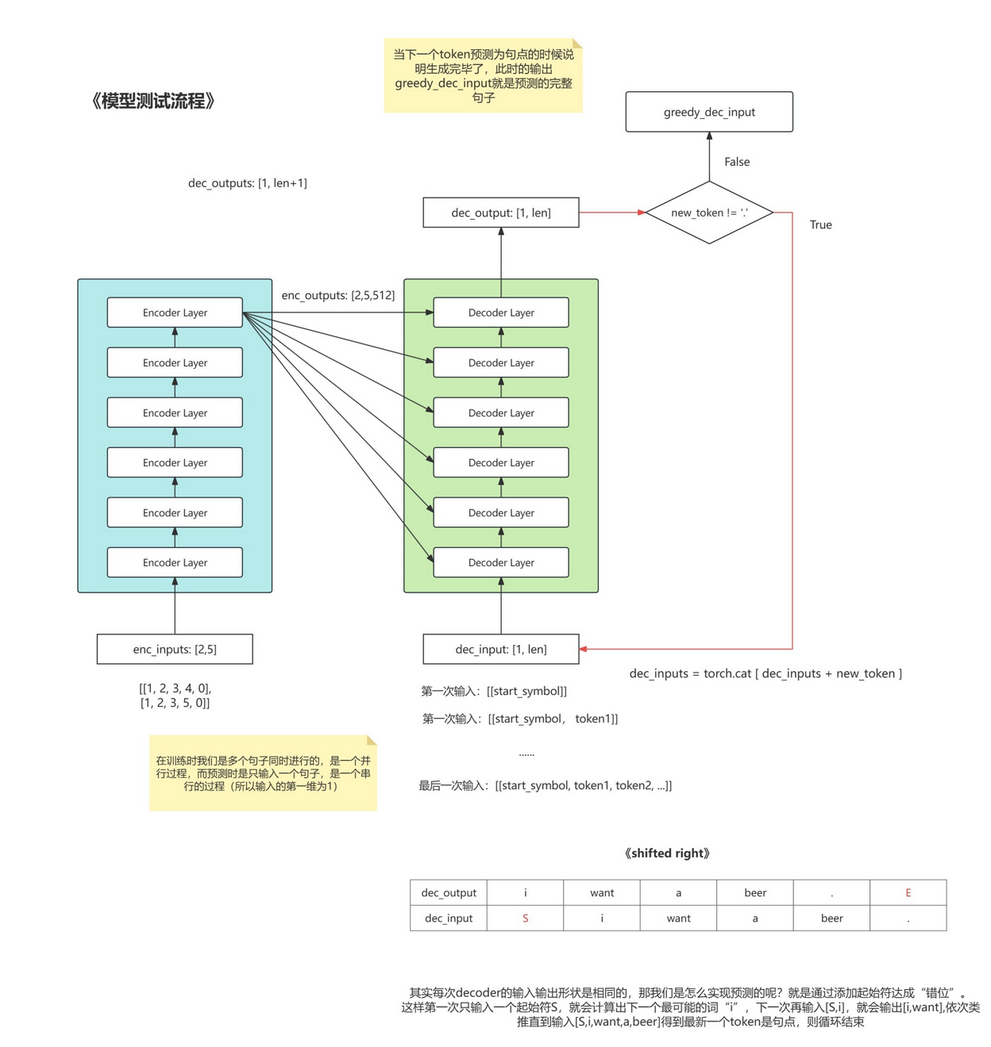